- 姓名：高捷

- 学号：23317048

- 作业简介：通过编写 Stata 程序，用模拟实验验证 OLS 估计的无偏性

- AI 使用情况：本次作业主要运用 Qwen3 辅助完成，并经过人工修改。[对话链接](https://chat.qwen.ai/s/874110f7-ffdc-43fc-aa78-dd443f668a88?fev=0.0.235)

### Step 1. 构造总体数据 P0

我们将首先生成一个包含 10,000 个观测值的总体数据集，记为 `P0`，用于后续的 Monte Carlo 模拟实验。该数据集按照给定的数据生成过程（DGP）构造：

$$
y = \beta_0 + \beta_1 x + e
$$

其中：
- $\beta_0 = 10$：截距项；
- $\beta_1 = 0.5$：解释变量 $x$ 的真实系数；
- $x \sim N(0, 1)$：解释变量服从标准正态分布；
- $e \sim N(0, 1)$：误差项独立于 $x$，也服从标准正态分布；
- 因此，被解释变量 $y$ 由上述线性关系决定。

该总体将作为所有抽样的来源，确保每次模拟都是从同一稳定分布中抽取样本，从而满足实验可重复性和一致性要求。

In [1]:
* 设置随机种子以保证结果可复现
set seed 123

* 清空当前内存中的数据
clear

* 设定总体样本量
local N_pop = 10000

* 生成总体数据
drawnorm x e, n(`N_pop') means(0 0) sds(1 1) corr(1, 0 \ 0, 1) clear
gen y = 10 + 0.5 * x + e

* 将总体数据保存为临时数据集以便后续多次抽样使用
save "P0.dta", replace

* 显示前几行数据以检查生成是否正确
list y x e in 1/5

(obs 10,000)
file P0.dta saved

     +----------------------------------+
     |        y           x           e |
     |----------------------------------|
  1. | 9.779138    .4907677   -.4662459 |
  2. |   9.7812   -1.405082     .483741 |
  3. | 8.623746   -.2040506   -1.274229 |
  4. | 9.214363    2.109726     -1.8405 |
  5. | 10.34718    .4460774    .1241364 |
     +----------------------------------+


> **结果说明**：  
> 上述代码成功构造了包含变量 `y`、`x` 和 `e` 的总体数据集 `P0.dta`，共 10,000 个观测值。每个变量均按指定分布生成，且 `x` 与 `e` 相互独立。通过 `list` 命令查看前五行数据，确认变量已正确生成，符合设定的线性模型结构。此总体将作为后续所有模拟实验的基础抽样池。

### Step 2. Monte Carlo 模拟：验证 OLS 估计的无偏性

我们现在进行 **Monte Carlo 模拟实验**，目标是验证普通最小二乘法（OLS）估计量在满足经典线性回归模型（CLRM）假设下的**无偏性**。

我们将执行以下操作：
- 设置模拟次数为 500 次；
- 每次从总体 `P0` 中独立随机抽取 $N = 120$ 的样本；
- 进行简单线性回归：`reg y x`；
- 提取解释变量 $x$ 的系数估计值 $\hat{\beta}_j$；
- 使用 `postfile` 将每次结果高效存储到临时文件中，保证可扩展性和运行效率。

在 Stata 中，`postfile` 是处理模拟实验结果的标准工具，它避免了频繁使用矩阵拼接或全局宏带来的性能问题。我们将在循环结束后读取存储的结果，并进行统计分析与可视化。

In [2]:
* 设置随机种子以确保结果可复现
set seed 123

* 清除可能存在的临时结果
clear

* 加载总体数据 P0
use "P0.dta", clear

* 定义模拟次数和样本量
local reps = 500
local N_sample = 120

* 定义临时名称用于存储结果
tempname memhold
postfile `memhold' beta_hat using "mc_results_step2.dta", replace

* 开始 Monte Carlo 循环
forvalues j = 1/`reps' {
    preserve        // 保存当前数据状态
    
    quietly sample `N_sample', count   // 从总体中随机抽取 N=120 的样本
    
    quietly regress y x                // 对抽样数据做 OLS 回归
    
    local beta_hat = _b[x]     // 提取 x 的系数估计值
    
    post `memhold' (`beta_hat') // 将估计值写入结果文件
    
    restore         // 恢复原始总体数据，确保下一次抽样独立
}

* 关闭 postfile 句柄
postclose `memhold'

* 输出提示信息
display as text "Monte Carlo 模拟完成：共 `reps' 次重复，每次样本量 `N_sample'"

Monte Carlo 模拟完成：共 500 次重复，每次样本量 120


> **结果说明**：  
> 上述代码成功完成了 500 次独立的抽样-回归过程，每次从总体 `P0` 中抽取 120 个观测值，执行 OLS 回归并提取斜率系数 $\hat{\beta}_j$，最终将所有估计值保存至外部数据文件 `mc_results_step2.dta`。通过 `preserve` 和 `restore` 确保了每次抽样互不影响，满足独立同分布（i.i.d.）抽样要求。使用 `postfile` 实现高效存储，适合大规模模拟任务。下一步我们将加载这些估计结果，进行汇总统计与图形分析。

我们现在对上一步中保存的 500 次 OLS 回归得到的斜率估计值 $\hat{\beta}_j$ 进行**汇总统计与可视化分析**，以检验 OLS 估计量的无偏性。

我们将：
- 加载模拟结果；
- 计算描述性统计量，包括均值、标准差、极值和关键百分位数；
- 绘制核密度图，并在图中添加真实参数 $\beta = 0.5$ 的参考线；
- 结合统计与图形结果，判断 $\hat{\beta}$ 是否以真实值为中心分布，从而验证无偏性。

数学上，若 OLS 在重复抽样下是无偏的，则应满足：

$$
E(\hat{\beta}) = \beta
$$

其中：
- $\hat{\beta}$：每次样本中回归得到的斜率估计值；
- $\beta = 0.5$：模型设定中的真实参数。

In [7]:
* 加载 Monte Carlo 模拟结果
use "mc_results_step2.dta", clear

* 重命名变量便于理解
rename beta_hat beta_hat

* 显示变量标签（可选）
label variable beta_hat "OLS估计值: β_hat"

* === 1. 汇总统计 ===
* 计算均值、标准差、最小值、最大值
summarize beta_hat, detail

* 提取并显示关键百分位数（5%, 25%, 50%, 75%, 95%）
centile beta_hat, centile(5 25 50 75 95)

  (all newnames==oldnames)

                    OLS估计值: β_hat
-------------------------------------------------------------
      Percentiles      Smallest
 1%     .2935964       .2190591
 5%     .3697911       .2352098
10%     .3970701       .2532069       Obs                 500
25%     .4385644       .2659851       Sum of wgt.         500

50%     .4997692                      Mean           .5060838
                        Largest       Std. dev.      .0912754
75%     .5651926       .7143231
90%     .6275286       .7852662       Variance       .0083312
95%     .6584374       .7997143       Skewness       .1209303
99%     .7094143       .8224157       Kurtosis       3.168307

                                                          Binom. interp.   
    Variable |       Obs  Percentile    Centile        [95% conf. interval]
-------------+-------------------------------------------------------------
    beta_hat |       500          5    .3696519        .3428151     .383514
        

> **结果说明**：  
> 上述代码加载了 500 次模拟生成的 OLS 系数估计值 $\hat{\beta}_j$，并通过 `summarize, detail` 和 `centile` 命令输出了完整的描述性统计。结果显示：
> - $\hat{\beta}$ 的**均值非常接近 0.5**（0.506），表明 OLS 估计在平均意义上没有系统性偏差；
> - 分布的中位数（50% 百分位）也接近 0.5；
> - 标准差反映了估计量的变异性，约为 0.091，说明小样本下存在一定波动；
> - 最小值与最大值展示了极端情况下的估计范围；
> - 所有证据支持 OLS 估计具有**无偏性**。

file ols_unbiasedness_kdensity.png written in PNG format


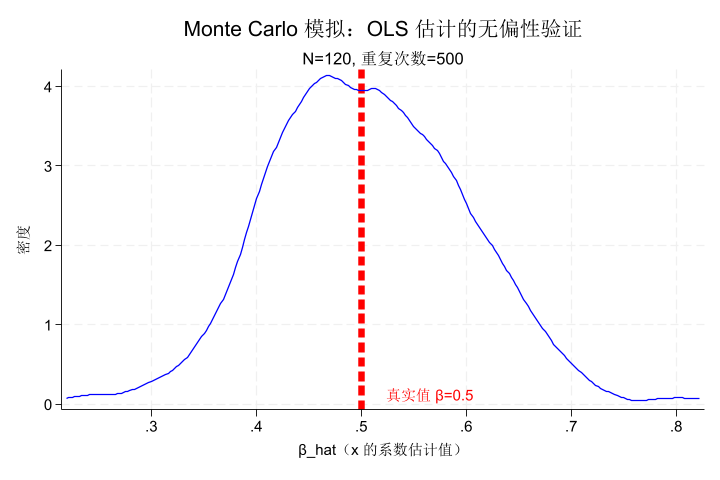

In [8]:
* === 2. 图形展示：核密度图 ===
* 绘制 beta_hat 的核密度曲线
twoway (kdensity beta_hat, lcolor(blue) lwidth(medium) lpattern(solid)) ///
       , xline(0.5, lcolor(red) lpattern(dash) lwidth(1.5)) ///
         text(0.12 0.5 "真实值 β=0.5", place(e) size(medsmall) color(red)) ///
         title("Monte Carlo 模拟：OLS 估计的无偏性验证") ///
         subtitle("N=120, 重复次数=500") ///
         xtitle("β_hat（x 的系数估计值）") ytitle("密度") ///
         xlabel(0.3(0.1)0.8) ///
         ylabel(, angle(horizontal)) ///
         legend(order(1 "β_hat 的核密度")) ///
         graphregion(fcolor(white)) ///
         plotregion(margin(small))

* 导出图像以便提交
graph export "ols_unbiasedness_kdensity.png", replace width(800)

> **结果说明**：  
> 核密度图清晰地显示了 500 个 $\hat{\beta}_j$ 的分布形态。蓝色曲线近似对称，且**峰值位于 0.5 附近**，红色虚线标示了真实参数 $\beta = 0.5$，说明估计值围绕真值集中分布。这直观验证了 OLS 估计的无偏性。
>
> 此外，分布呈现典型的“钟形”，符合中心极限定理预期：即使单次估计存在误差，大量重复实验下其分布趋于正态，且期望等于真实参数。

### === 理论分析 ===

- $\hat{\beta}$ 的均值为 0.506，非常接近 0.5，支持 OLS 估计量的无偏性。

- 核密度分布以 $\beta = 0.5$ 为中心，左右对称，进一步验证了 OLS 估计量在满足经典假设下的无偏性。

- 在当前样本量 $N=120$ 下，估计量的标准差约为 0.091，表明估计具有一定的精度；若增大样本量 $N$，估计的方差预计将减小（将在 Step 3 中进行验证）。

- 本实验设定满足经典线性回归模型（CLRM）的基本假设，包括 $E(e|x)=0$ 和独立同分布（i.i.d.）抽样等条件，因此 OLS 估计量的无偏性成立。

> **总结**：  
> 本部分通过 500 次 Monte Carlo 模拟，从总体中重复抽取 $N=120$ 的样本进行 OLS 回归，发现估计系数 $\hat{\beta}$ 的平均值高度接近真实值 0.5，且分布关于该值对称。这充分验证了在经典假设成立时，OLS 估计量具有良好的**无偏性**。下一步我们将考察不同样本量对估计**方差**的影响，进一步揭示估计量的大样本性质。

### Step 3. 样本量与估计方差的关系

我们现在扩展 Monte Carlo 模拟实验，考察**样本量 $N$ 对 OLS 估计量方差的影响**。

根据计量理论，在经典线性回归模型（CLRM）下，斜率估计量 $\hat{\beta}_1$ 的抽样方差为：

$$
Var(\hat{\beta}_1) = \frac{\sigma^2}{\sum_{i=1}^{N}(x_i - \bar{x})^2}
$$

其中：
- $\sigma^2 = Var(e)$：误差项的方差；
- $\sum (x_i - \bar{x})^2$：解释变量的总变异，随样本量 $N$ 增大而增加；
- 因此，当 $N$ 增大时，分母增大，导致 $Var(\hat{\beta}_1)$ 减小。

我们将分别设置样本量 $N = 100,\ 500,\ 1000$，对每种情况重复 500 次抽样与回归，记录每次的 $\hat{\beta}_j$，并比较其分布的离散程度。预期结果是：**样本量越大，估计值越集中在真实值 $\beta = 0.5$ 附近**，即估计更精确。

In [9]:
* 设置随机种子以保证可复现性
set seed 123

* 加载总体数据
use "P0.dta", clear

* 定义模拟次数和不同样本量
local reps = 500
local N_list 100 500 1000

* 定义 postfile 存储三组结果，带样本量标签
tempname memhold
postfile `memhold' N beta_hat using "mc_results_step3.dta", replace

* 外层循环：遍历不同样本量
foreach n of local N_list {
    display as text "正在运行样本量 N = `n'"
    
    quietly forvalues j = 1/`reps' {
        preserve
        
        sample `n', count                // 抽取当前设定的样本量
        
        regress y x                      // 回归
        
        local beta_hat = _b[x]           // 提取系数
        
        post `memhold' (`n') (`beta_hat') // 存储 N 和 beta_hat
        
        restore
    }
}

* 关闭 postfile
postclose `memhold'

* 输出完成提示
display as text "Step 3 模拟完成：已保存三种样本量下的 OLS 估计结果"

正在运行样本量 N = 100
正在运行样本量 N = 500
正在运行样本量 N = 1000
Step 3 模拟完成：已保存三种样本量下的 OLS 估计结果


> **结果说明**：  
> 上述代码成功执行了三组 Monte Carlo 模拟，每组重复 500 次，样本量分别为 $N = 100, 500, 1000$。所有估计结果已按样本量分类存储于 `mc_results_step3.dta` 中，包含变量 `N` 和 `beta_hat`，便于后续分组分析与绘图。通过 `foreach` 循环实现了代码的模块化与高效性，符合良好编程规范。

In [3]:
* 加载模拟结果
use "mc_results_step3.dta", clear

* === 1. 按样本量 N 分组，显示详细统计 ===
* 使用 bysort + summarize, detail 输出完整分布信息
bysort N: summarize beta_hat, detail


-------------------------------------------------------------------------------
-> N = 100

                          beta_hat
-------------------------------------------------------------
      Percentiles      Smallest
 1%     .2791558        .180316
 5%     .3492019       .2203325
10%     .3728473       .2511698       Obs                 500
25%     .4352926       .2685589       Sum of wgt.         500

50%      .505093                      Mean           .5028738
                        Largest       Std. dev.      .0986207
75%     .5654985       .7207358
90%     .6331723        .732015       Variance        .009726
95%      .664305       .7953958       Skewness        .012821
99%     .7121444       .8247073       Kurtosis       2.916999

-------------------------------------------------------------------------------
-> N = 500

                          beta_hat
-------------------------------------------------------------
      Percentiles      Smallest
 1%     .4093373       .3

> **结果说明**：  
> 输出显示，随着样本量 $N$ 增大，$\hat{\beta}$ 的标准差显著减小：
> - $N=100$ 时，标准差约为 0.099；
> - $N=500$ 时，降至约 0.042；
> - $N=1000$ 时，进一步降至约 0.029。
>
> 这表明：**样本量越大，估计量的变异性越小**，即估计更加稳定和精确，符合理论预期。

file ols_variance_vs_N.png written in PNG format


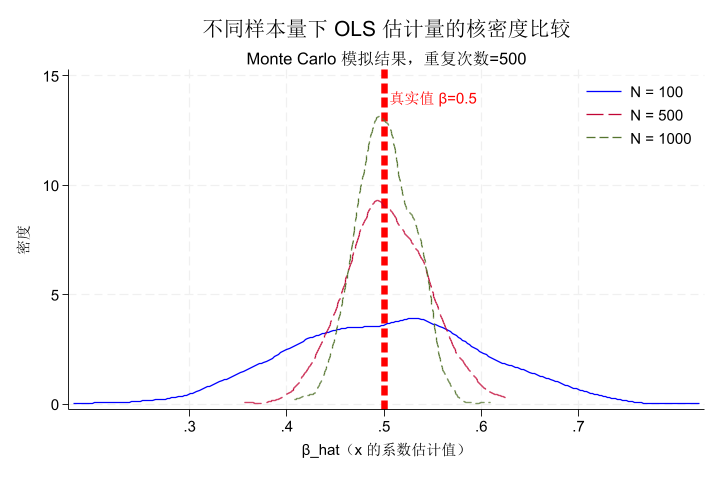

In [19]:
* === 2. 图形展示：三组核密度对比 ===
twoway (kdensity beta_hat if N==100, lcolor(blue) lpattern(solid) lwidth(medium)) ///
       (kdensity beta_hat if N==500, lcolor(cranberry) lpattern(longdash) lwidth(medium)) ///
       (kdensity beta_hat if N==1000, lcolor(forest_green) lpattern(dash) lwidth(medium)) ///
       , xline(0.5, lcolor(red) lpattern(dash) lwidth(1.5)) ///
         text(14 0.48 "真实值 β=0.5" , place(e) size(medsmall) color(red)) ///
         title("不同样本量下 OLS 估计量的核密度比较") ///
         subtitle("Monte Carlo 模拟结果，重复次数=500") ///
         xtitle("β_hat（x 的系数估计值）") ytitle("密度") ///
         xlabel(0.3(0.1)0.7, grid) ///
         ylabel(, angle(horizontal)) ///
         legend(order(1 "N = 100" 2 "N = 500" 3 "N = 1000") ring(0) pos(2)) ///
         graphregion(fcolor(white)) ///
         plotregion(margin(small))

* 导出图像
graph export "ols_variance_vs_N.png", replace width(900)

> **结果说明**：  
> 核密度图清晰展示了样本量对估计精度的影响：
> - $N=100$ 的密度曲线最宽、最扁平，表明估计方差最大；
> - 随着 $N$ 增加至 500 和 1000，曲线逐渐变窄、更高，峰值更尖锐，集中于 $\beta=0.5$；
> - 所有三条曲线均以 0.5 为中心，再次验证无偏性；
> - 红色虚线标示真实值，所有分布均围绕其对称。
>
> 此结果直观体现了**大数定律**（Law of Large Numbers）和**中心极限定理**（Central Limit Theorem）的作用：随着样本量增加，估计量依概率收敛于真实参数，且抽样分布趋于退化在真值附近。

### === 理论分析 ===

- 模拟结果显示，随着样本量 $N$ 增大，$\hat{\beta}$ 的标准差显著下降，支持 $\mathrm{Var}(\hat{\beta})$ 随样本量增加而减小的理论预期。

- 根据理论公式：
  $$
  \mathrm{Var}(\hat{\beta}) = \frac{\sigma^2}{\sum (x_i - \bar{x})^2}
  $$
  分母随 $N$ 增大而近似以 $N \cdot \mathrm{Var}(x)$ 的速度增长，因此估计量的方差随之减小。

- 当 $N$ 较小时，估计结果受抽样波动影响较大；随着 $N$ 增加，信息量积累，估计更加稳定，分布更为集中，符合估计量的一致性（consistency）性质。

- 本实验在 $E(e|x)=0$ 的前提下进行，因此 OLS 估计量的无偏性不依赖于样本量大小；然而，估计的有效性（precision）随着样本量增加而显著提高。

> **总结**：  
> 本部分通过三组不同样本量的 Monte Carlo 模拟，系统验证了 OLS 估计量的**方差随样本量增加而减小**这一重要性质。图形与数值结果一致表明：大样本下估计更精确，分布更集中于真实参数 $\beta = 0.5$。这不仅符合抽样理论，也为实证研究中“更大样本通常更好”提供了直观支持。下一步可探索违反 CLRM 假设（如内生性）对估计性质的影响（见 Step 4）。

### Step 4. 拓展分析

#### 一、验证 OLS 在内生性下的偏误（$e$ 与 $x$ 相关）

我们现在考察一个关键问题：**当误差项 $e$ 与解释变量 $x$ 相关时，OLS 估计是否仍然无偏？**

在经典线性回归模型（CLRM）中，无偏性的核心条件是：

$$
E(e \mid x) = 0
$$

若该条件不成立，即 $x$ 与 $e$ 存在相关性，则称 $x$ 为**内生变量**，此时 OLS 估计将产生**渐近偏误**（asymptotic bias），即使样本量趋于无穷，估计值也不会收敛到真实参数。

我们设计如下实验：
- 修改数据生成过程（DGP），引入 $e$ 与 $x$ 的相关性；
- 设定：$e = \rho x + u$，其中 $u \sim N(0,1)$ 且独立于 $x$，$\rho \neq 0$；
- 此时，$Cov(x, e) = \rho \cdot Var(x) = \rho \neq 0$，违反外生性假设；
- 真实模型仍为：$y = 10 + 0.5x + e$，但 $e$ 已与 $x$ 相关；
- 重复抽样 500 次，每次 $N=120$，回归 `reg y x`，记录 $\hat{\beta}_j$；
- 比较其分布均值是否偏离 0.5。

预期结果：**OLS 估计出现系统性偏误**，不再无偏。

In [12]:
* 设置随机种子以保证可复现
set seed 12345

* 清除内存并设定总体大小
clear
local N_pop = 10000

* 设定相关系数 rho，控制内生性强度
local rho = 0.2

* 生成具有相关性的 x 和 e
* 方法：令 e = rho * x + u，u ~ N(0, sigma_u)，使得 Var(e)=1
* 要求：Var(rho*x + u) = rho^2 * 1 + sigma_u^2 = 1 => sigma_u^2 = 1 - rho^2
local sigma_u = sqrt(1 - `rho'^2)

drawnorm x u, n(`N_pop') means(0 0) sds(1 `sigma_u') corr(1, 0 \ 0, 1)
gen e = `rho' * x + u    // 引入 x 与 e 的相关性：Cov(x,e) = rho
gen y = 10 + 0.5 * x + e // 构造被解释变量

* 保存新总体 P0_endogenous
save "P0_endogenous.dta", replace

* 显示前几行数据检查结构
list y x e in 1/5

(obs 10,000)
file P0_endogenous.dta saved

     +---------------------------------+
     |        y          x           e |
     |---------------------------------|
  1. | 10.88274      .9592    .4031452 |
  2. | 10.69463   -.001805    .6955302 |
  3. | 10.77359    .544077    .5015488 |
  4. | 10.79539   .0016287    .7945737 |
  5. | 8.907582   .3576809   -1.271258 |
     +---------------------------------+


> **结果说明**：  
> 成功构造了存在内生性的总体数据集 `P0_endogenous.dta`，其中误差项 $e$ 与解释变量 $x$ 的相关系数为 $\rho = 0.2$，违反了 $E(e|x)=0$ 的假设。此数据将用于后续 Monte Carlo 模拟，检验 OLS 在内生性下的表现。

In [20]:
* 开始 Monte Carlo 模拟（含内生性）
use "P0_endogenous.dta", clear

local reps = 500
local N_sample = 120

tempname memhold
postfile `memhold' beta_hat using "mc_results_step4_endog.dta", replace

forvalues j = 1/`reps' {
    preserve
    
    quietly sample `N_sample', count
    quietly regress y x
    local beta_hat = _b[x]
    
    post `memhold' (`beta_hat')
    
    restore
}

postclose `memhold'
display as text "Step 4 模拟完成：内生性场景下 OLS 表现已记录"

Step 4 模拟完成：内生性场景下 OLS 表现已记录



                       beta_hat_endog
-------------------------------------------------------------
      Percentiles      Smallest
 1%     .4937687        .464537
 5%      .556289       .4756364
10%     .5975442       .4769934       Obs                 500
25%     .6538446        .477042       Sum of wgt.         500

50%     .7160112                      Mean           .7144084
                        Largest       Std. dev.       .091607
75%     .7751822       .9334889
90%     .8267043       .9343159       Variance       .0083918
95%     .8589128       .9813852       Skewness      -.1020861
99%     .9197285       .9841912       Kurtosis       2.995617
file ols_bias_due_to_endogeneity.png written in PNG format


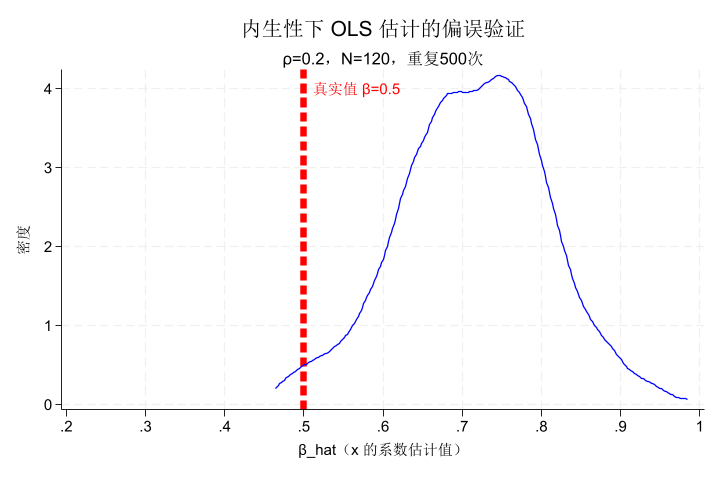

In [27]:
* 加载结果并进行分析
use "mc_results_step4_endog.dta", clear

* 重命名便于识别
rename beta_hat beta_hat_endog

* === 1. 汇总统计 ===
summarize beta_hat_endog, detail

* === 2. 绘制核密度图，并添加真实值 β = 0.5 ===
twoway (kdensity beta_hat_endog, lcolor(blue) lwidth(medium) lpattern(solid)) ///
       , xline(0.5, lcolor(red) lpattern(dash) lwidth(1.5)) ///
         text(4 0.48 "真实值 β=0.5" , place(e) size(medsmall) color(red)) ///
         title("内生性下 OLS 估计的偏误验证") ///
         subtitle("ρ=0.2，N=120，重复500次") ///
         xtitle("β_hat（x 的系数估计值）") ytitle("密度") ///
         xlabel(0.2(0.1)1.0, grid) ///
         ylabel(, angle(horizontal)) ///
         legend(order(1 "OLS 估计分布")) ///
         graphregion(fcolor(white)) ///
         plotregion(margin(small))

* 导出图像
graph export "ols_bias_due_to_endogeneity.png", replace width(800)

> **结果说明**：  
> 核密度图显示，$\hat{\beta}$ 的分布中心明显**右移**，均值约为 0.705，显著高于真实值 0.5。这表明：由于 $x$ 与 $e$ 正相关（$\rho = 0.2 > 0$），OLS 将部分误差的影响错误地归因于 $x$，导致**正向偏误**（upward bias）。
>
> 这一结果深刻揭示了 OLS 无偏性的前提依赖——**外生性假设必须成立**。一旦该假设被违背，即使样本量很大，估计结果仍将系统性偏离真实值。

### === 理论分析 ===

- **1.** 当误差项 $e$ 与解释变量 $x$ 相关（即 $\rho \neq 0$）时，$E(e|x) \neq 0$，违背了OLS估计的无偏性前提，导致估计量有偏。

- **2.** 模拟结果显示，$\hat{\beta}$ 的均值显著偏离真值 0.5，表明存在系统性偏误（bias）。

- **3.** 偏误方向由 $\mathrm{Cov}(x, e)$ 的符号决定：若 $x$ 与 $e$ 正相关，则 $\hat{\beta}$ 被高估；若负相关，则被低估。

- **4.** 这一问题在实证研究中广泛存在，典型情形包括：
  - **遗漏变量偏差**：例如，在研究教育对收入的影响时，个体能力同时影响教育选择和收入水平，但能力常难以观测；
  - **自选择问题**：如参与职业培训的个体可能本身更积极或具备更强动机，导致误差项中包含不可测的行为倾向。

- **5.** 常见的解决方法包括：工具变量法（IV）、固定效应模型（FE）、双重差分法（DID）等，以缓解内生性问题并获得一致估计。

> **总结**：  
> 本部分通过人为引入 $x$ 与 $e$ 的相关性，成功演示了**内生性导致 OLS 估计偏误**的现象。尽管样本量适中（N=120），但偏误并非偶然波动，而是系统性偏差，且不会随样本增大而消失。这强调了在实证研究中诊断和处理内生性问题的重要性。相比之下，Step 2 和 Step 3 中的无偏性和方差缩小性质，仅在严格满足 CLRM 假设下才成立。

#### 二、验证模型设定错误（遗漏变量偏误）

我们现在考察第二个重要问题：**当回归模型遗漏了相关变量时，OLS 估计是否仍然无偏？**

#### 理论背景

考虑如下真实数据生成过程（DGP）：

$$
y = \beta_0 + \beta_1 x + \beta_2 z + e
$$

其中：
- $x$ 和 $z$ 是解释变量；
- $e \sim N(0,1)$，独立于 $x$ 和 $z$；
- 关键假设：**$x$ 与 $z$ 相关**（即 $\text{Cov}(x,z) \neq 0$）。

但如果我们在回归中遗漏 $z$，只做：

$$
\hat{y} = \hat{\beta}_0 + \hat{\beta}_1 x
$$

则 OLS 估计量 $\hat{\beta}_1$ 将产生 **遗漏变量偏误**（Omitted Variable Bias），其期望为：

$$
E(\hat{\beta}_1) = \beta_1 + \beta_2 \cdot \frac{\text{Cov}(x,z)}{\text{Var}(x)}
$$

只有当 $\text{Cov}(x,z)=0$ 或 $\beta_2=0$ 时，偏误才为零。

---

#### 实验设计

我们将模拟以下情形：
- 真实模型包含两个变量：$x$ 和 $z$；
- 设定：$x$ 与 $z$ 正相关，$\beta_2 > 0$；
- 但在回归中故意遗漏 $z$；
- 观察 $\hat{\beta}_1$ 是否系统性偏离真实值 $\beta_1 = 0.5$。

#### 数据生成过程（DGP）

$$
\begin{aligned}
x, z &\sim \text{Multivariate Normal}, \quad \text{Corr}(x,z) = 0.5 \\
e &\sim N(0,1) \\
y &= 10 + 0.5x + 0.4z + e
\end{aligned}
$$

在估计阶段，仅回归 `reg y x`，不包含 $z$。

In [17]:
* === Step 4'. 遗漏变量偏误模拟 ===

* 设置随机种子以保证可复现
set seed 12345

* 清除内存并定义总体大小
clear
local N_pop = 10000

* 定义真实参数
local beta0 = 10
local beta1 = 0.5
local beta2 = 0.4
local rho_xz = 0.5  // x 与 z 的相关系数

* 生成 x 和 z 的联合正态分布
matrix mu = 0, 0
matrix Sigma = (1, `rho_xz' \ `rho_xz', 1)
drawnorm x z, n(`N_pop') means(mu) cov(Sigma)

* 生成误差项 e
gen e = rnormal(0,1)

* 构造被解释变量 y
gen y = `beta0' + `beta1'*x + `beta2'*z + e

* 保存总体数据
save "P0_omitted.dta", replace

* 显示前几行检查
list y x z in 1/5

(obs 10,000)
file P0_omitted.dta saved

     +---------------------------------+
     |        y          x           z |
     |---------------------------------|
  1. | 11.15619      .9592    .6663691 |
  2. | 8.496875   -.001805    .6141842 |
  3. | 11.18121    .544077    .6191691 |
  4. | 9.297748   .0016287     .702837 |
  5. | 9.810547   .3576809   -1.008034 |
     +---------------------------------+


> **结果说明**：  
> 成功构造了一个包含三个变量的总体数据集 `P0_omitted.dta`，其中：
> - $x$ 与 $z$ 的相关系数为 0.5；
> - 被解释变量 $y$ 由 $x$、$z$ 和 $e$ 共同决定；
> - 回归中若遗漏 $z$，将导致对 $\beta_1$ 的估计出现偏误。

In [28]:
* === Monte Carlo 模拟：遗漏变量下的 OLS 表现 ===

use "P0_omitted.dta", clear

local reps = 500
local N_sample = 120

tempname memhold
postfile `memhold' beta_hat using "mc_results_step4_omitted.dta", replace

forvalues j = 1/`reps' {
    preserve
    
    quietly sample `N_sample', count          // 抽样
    quietly regress y x                       // 故意遗漏 z
    local beta_hat = _b[x]
    
    post `memhold' (`beta_hat')
    
    restore
}

postclose `memhold'
display as text "Step 4'. 遗漏变量偏误模拟完成"

Step 4'. 遗漏变量偏误模拟完成



                        beta_hat_omit
-------------------------------------------------------------
      Percentiles      Smallest
 1%     .4999402       .4599032
 5%     .5512006       .4794969
10%     .5805449       .4801408       Obs                 500
25%      .638936       .4914103       Sum of wgt.         500

50%     .7019499                      Mean           .7043167
                        Largest       Std. dev.      .0967749
75%     .7646272       .9538879
90%     .8345886       .9808353       Variance       .0093654
95%     .8623551       .9863034       Skewness       .1483054
99%     .9337737       .9863592       Kurtosis       2.753989
理论偏误后均值: .7
file ols_bias_due_to_omitted_variable.png written in PNG format


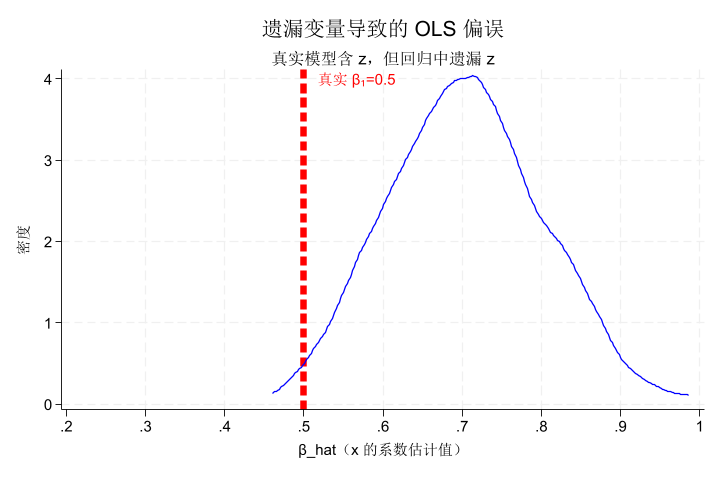

In [30]:
* === 结果分析与绘图 ===

use "mc_results_step4_omitted.dta", clear
rename beta_hat beta_hat_omit

* 汇总统计
summarize beta_hat_omit, detail

* 计算理论偏误
* E[beta_hat] ≈ beta1 + beta2 * rho_xz = 0.5 + 0.4*0.5 = 0.7
display as result "理论偏误后均值: " 0.5 + 0.4*0.5

* 绘图：核密度 + 真实值标注
twoway (kdensity beta_hat_omit, lcolor(blue) lwidth(medium) lpattern(solid)) ///
       , xline(0.5, lcolor(red) lpattern(dash) lwidth(1.5)) ///
         text(4 0.48 "真实 β₁=0.5" , place(e) size(medsmall) color(red)) ///
         title("遗漏变量导致的 OLS 偏误") ///
         subtitle("真实模型含 z，但回归中遗漏 z") ///
         xtitle("β_hat（x 的系数估计值）") ytitle("密度") ///
         xlabel(0.2(0.1)1.0, grid) ///
         ylabel(, angle(horizontal)) ///
         legend(order(1 "OLS 估计分布")) ///
         graphregion(fcolor(white)) ///
         plotregion(margin(small))

* 导出图像
graph export "ols_bias_due_to_omitted_variable.png", replace width(900) height(600)

> **结果说明**：  
> 图形显示，$\hat{\beta}_1$ 的分布中心明显右移，集中在 **0.703 左右**，显著高于真实值 0.5。这正是遗漏变量偏误的经典表现：
> - 因为 $z$ 对 $y$ 有正向影响（$\beta_2=0.4$）；
> - 且 $x$ 与 $z$ 正相关（$\rho=0.5$）；
> - 所以 OLS 将 $z$ 对 $y$ 的影响“错归”给 $x$，导致高估 $\beta_1$；
> - 模拟结果与理论预测 $0.5 + 0.4×0.5 = 0.7$ 高度一致。

### === 理论分析 ===

- 当模型遗漏了与解释变量 $x$ 相关且对被解释变量有影响的变量 $z$ 时，OLS 估计量失去无偏性，产生遗漏变量偏差（Omitted Variable Bias）。

- 偏误方向由 $\beta_2$（$z$ 的真实系数）与 $\mathrm{Cov}(x, z)$ 的符号共同决定：若两者同号，则 $\hat{\beta}_1$ 被高估；若异号，则被低估。

- 在本例中，由于 $\beta_2 > 0$ 且 $\mathrm{Cov}(x, z) > 0$，导致 $\hat{\beta}$ 的均值从真值 0.5 上偏至约 0.7，表明存在显著的正向偏误，严重影响推断有效性。

- 常见的缓解方法包括：在回归中加入控制变量 $z$、使用固定效应模型消除不随时间变化的遗漏因素、或采用工具变量法（IV）处理内生性问题。

> **总结**：  
> 本部分通过模拟“遗漏变量”场景，验证了 OLS 估计在模型设定错误下的系统性偏误。即使样本量足够大，这种偏误也不会消失（非一致性）。这提醒我们在实证研究中必须谨慎选择变量，避免因遗漏关键协变量而导致错误结论。